In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import math
import numpy as np
import copy
import time
import pickle
from random import seed, shuffle, sample

from sklearn.preprocessing import StandardScaler
from aif360.datasets import AdultDataset, CompasDataset, GermanDataset, BankDataset, StandardDataset

import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
sys.path.append('../baselines/iFair/')
sys.path.append('../baselines/LFR/')
sys.path.append('../baselines/PFR/')
sys.path.append('../iFlipper/')

from iflipper import iFlipper
from aif360.algorithms.preprocessing import LFR
from iFair import iFair
from PFR import PFR, similarity_pfr, estimate_dim

from cplex_solver import CPLEX_Solver
from greedy import Greedy
from gradient import Gradient

from utils import measure_violations, similarity_knn, similarity_threshold
from model import Model

# Load fairness dataset from AIF360 and define variables
### 1. Dataset = COMPAS, AdultCensus, Credit
### 2. Similarity matrix = knn, threshold
### 3. ML model = LogisticRegression, RandomForest, NeuralNetwork

In [3]:
dataset_type = "COMPAS" # AdultCensus, Credit
similarity_matrix = "knn" # threshold
model_type = "LogisticRegression" # RandomForest, NeuralNetwork

PRINT_RESULT = False  

In [4]:
if dataset_type == "COMPAS":
    dataset = CompasDataset(label_name='two_year_recid', favorable_classes=[0], 
                            protected_attribute_names=['sex'], privileged_classes=[['Female']], 
                            categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc', 'race'], 
                            features_to_keep=['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'two_year_recid'], 
                            features_to_drop=[], na_values=[])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    k, threshold = 20, 3
    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.001, 0]
    
elif dataset_type == "AdultCensus":
    dataset = AdultDataset(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], 
                    protected_attribute_names=['sex'], privileged_classes=[['Male']], 
                    categorical_features=['race', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], 
                    features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    k, threshold = 20, 3
    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0]
    
elif dataset_type == "Credit":
    def label_processing(df):
        credit_map = {1.0 : 1.0, 2.0 : 0.0}
        status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
                      'A92': 'female', 'A95': 'female'}
        df['credit'] = df['credit'].replace(credit_map)
        df['sex'] = df['personal_status'].replace(status_map)    
        return df
    
    dataset = GermanDataset(custom_preprocessing = label_processing, 
                            metadata={'label_maps': [{1.0: 'Good Credit', 0.0: 'Bad Credit'}], 'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}]})
    protected = "age"
    num_train, num_test, num_val = 0.7, 0.2, 0.1
    k, threshold = 20, 7
    num_plot = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]

privileged_groups = [{protected: 1}]
unprivileged_groups = [{protected: 0}]

In [5]:
scaler = StandardScaler()
train, test, val = dataset.split([num_train, num_train+num_test], shuffle=True, seed=0)

train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)
val.features = scaler.fit_transform(val.features)
index = train.feature_names.index(protected)

# remove sensitive features
x_train = np.delete(train.features, index, axis=1)
x_test = np.delete(test.features, index, axis=1)
x_val = np.delete(val.features, index, axis=1)

y_train = train.labels.ravel()
y_test = test.labels.ravel()
y_val = val.labels.ravel()

# keep sensitive column for PFR
train_sensitive = np.reshape(train.features[:, index], (-1, 1))
test_sensitive = np.reshape(test.features[:, index], (-1, 1))
val_sensitive = np.reshape(val.features[:, index], (-1, 1))

# For iFair
x_train_with_sensitive = np.concatenate((x_train, train_sensitive), axis = 1)
x_test_with_sensitive = np.concatenate((x_test, test_sensitive), axis = 1)
x_val_with_sensitive = np.concatenate((x_val, val_sensitive), axis = 1)

print("Dataset: %s" % dataset_type)
print("Number of training data: %d, Number of test data: %d, Number of validation data: %d\n" % (x_train.shape[0], x_test.shape[0], x_val.shape[0]))

Dataset: COMPAS
Number of training data: 3700, Number of test data: 1850, Number of validation data: 617



# Obtain similarity matrix

In [6]:
if similarity_matrix == "knn":
    w_train, edge_train = similarity_knn(x_train, k)
    w_test, edge_test = similarity_knn(x_test, k)
    w_val, edge_val = similarity_knn(x_val, k)
    
elif similarity_matrix == "threshold":
    w_train, edge_train = similarity_threshold(x_train, threshold)
    w_test, edge_test = similarity_threshold(x_test, threshold)
    w_val, edge_val = similarity_threshold(x_val, threshold)

# Original result (without any pre-processing)

In [7]:
test_accuracy, test_consistency_score, runtime = dict(), dict(), dict()

model = Model(model_type, x_train, y_train, w_train, edge_train, x_test, y_test, w_test, edge_test, x_val, y_val)
train_performance, test_performance = model.train()

test_accuracy["Original"], test_consistency_score["Original"] = [test_performance[0]], [test_performance[1]]
print(f"Test Accuracy: {test_performance[0]:.5f}")
print(f"Test Consistency Score: {test_performance[1]:.5f}")

Test Accuracy: 0.68811
Test Consistency Score: 0.72307


# iFlipper on different target violation limits (m)

In [8]:
method = "iFlipper"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

init_violations = measure_violations(y_train, edge_train)
for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    IFLIP = iFlipper(y_train, w_train, edge_train)
    flipped_label = IFLIP.transform(m)
    elapsed_time = time.time() - start

    model = Model(model_type, x_train, flipped_label, w_train, edge_train, x_test, y_test, w_test, edge_test, x_val, y_val)
    train_performance, test_performance = model.train()

    test_accuracy[method].append(test_performance[0])
    test_consistency_score[method].append(test_performance[1])
    runtime[method].append(elapsed_time)
    
    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {measure_violations(flipped_label, edge_train)}")
        print(f"Number of flips: {np.sum(y_train != flipped_label)}")
        print(f"Test Accuracy: {test_performance[0]:.5f}") 
        print(f"Test Consistency Score: {test_performance[1]:.5f}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

# LFR (Learning Fair Representations, ICML 2013)
## Implemented in AIF360 toolkit

In [9]:
IMPORT_RESULT = True

method = "LFR"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

if IMPORT_RESULT:
    with open(f'../baselines/LFR/{method}_{dataset_type}_{num_train}.pkl', 'rb') as f:
        save_dict = pickle.load(f)
        
    grid = len(save_dict["Ax"])
    for i in range(grid):
        TR = save_dict["TR"][i]
        Ax = save_dict["Ax"][i]
        Ay = save_dict["Ay"][i]
        Az = save_dict["Az"][i]
        elapsed_time = save_dict["elapsed_time"][i]
        
        start = time.time()
        transf_train = TR.transform(train)
        transf_test = TR.transform(test)
        transf_val = TR.transform(val)

        transf_x_train = np.delete(transf_train.features, index, axis=1)
        transf_x_test = np.delete(transf_test.features, index, axis=1)
        transf_x_val = np.delete(transf_val.features, index, axis=1)
        elapsed_time = (time.time() - start) + elapsed_time

        model = Model(model_type, transf_x_train, y_train, w_train, edge_train, transf_x_test, y_test, w_test, edge_test, transf_x_val, y_val)
        train_performance, test_performance = model.train()

        test_accuracy[method].append(test_performance[0])
        test_consistency_score[method].append(test_performance[1])
        runtime[method].append(elapsed_time)

        if PRINT_RESULT:
            print("============================")
            print(f"Ax:{Ax}, Ay:{Ay}, Az:{Az}")
            print(f"Test Accuracy: {test_performance[0]:.5f}") 
            print(f"Test Consistency Score: {test_performance[1]:.5f}")
            print(f"Runtime (sec): {elapsed_time:.5f}")
    
else:
    for Ax in [0.01]:
        for Ay in [0.1, 0.5, 1, 5]:
            for Az in [0, 0.1, 0.5, 1, 5]:
                start = time.time()
                TR = LFR(unprivileged_groups=unprivileged_groups,
                            privileged_groups=privileged_groups,
                            k=k, Ax=Ax, Ay=Ay, Az=Az,
                            verbose=0)
                TR = TR.fit(train)

                transf_train = TR.transform(train)
                transf_test = TR.transform(test)
                transf_val = TR.transform(val)

                transf_x_train = np.delete(transf_train.features, index, axis=1)
                transf_x_test = np.delete(transf_test.features, index, axis=1)
                transf_x_val = np.delete(transf_val.features, index, axis=1)
                elapsed_time = (time.time() - start)

                model = Model(model_type, transf_x_train, y_train, w_train, edge_train, transf_x_test, y_test, w_test, edge_test, transf_x_val, y_val)
                train_performance, test_performance = model.train()

                test_accuracy[method].append(test_performance[0])
                test_consistency_score[method].append(test_performance[1])
                runtime[method].append(elapsed_time)

                if PRINT_RESULT:
                    print("============================")
                    print(f"Ax:{Ax}, Ay:{Ay}, Az:{Az}")
                    print(f"Test Accuracy: {test_performance[0]:.5f}") 
                    print(f"Test Consistency Score: {test_performance[1]:.5f}")
                    print(f"Runtime (sec): {elapsed_time:.5f}")

# iFair (Learning individually fair data representations for algorithmic decision making, ICDE 2019)
## https://github.com/plahoti-lgtm/iFair

In [10]:
IMPORT_RESULT = True

method = "iFair"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

save_name = f'../baselines/iFair/{method}_{dataset_type}_{num_train}.pkl'
if IMPORT_RESULT:
    with open(save_name, 'rb') as f:
        save_dict = pickle.load(f)

    grid = len(save_dict["Ax"])
    for i in range(grid):
        iF = save_dict["iF"][i]
        Ax = save_dict["Ax"][i]
        Az = save_dict["Az"][i]
        k = save_dict["k"][i]
        elapsed_time = save_dict["elapsed_time"][i]
        
        start = time.time()
        transf_x_train = iF.transform(x_train_with_sensitive)
        transf_x_test = iF.transform(x_test_with_sensitive)
        transf_x_val = iF.transform(x_val_with_sensitive)

        transf_x_train = np.delete(transf_x_train, -1, axis=1)
        transf_x_test = np.delete(transf_x_test, -1, axis=1)
        transf_x_val = np.delete(transf_x_val, -1, axis=1)
        elapsed_time = (time.time() - start) + elapsed_time

        model = Model(model_type, transf_x_train, y_train, w_train, edge_train, transf_x_test, y_test, w_test, edge_test, transf_x_val, y_val)
        train_performance, test_performance = model.train()

        test_accuracy[method].append(test_performance[0])
        test_consistency_score[method].append(test_performance[1])
        runtime[method].append(elapsed_time)

        if PRINT_RESULT:
            print("============================")
            print(f"Ax:{Ax}, Az:{Az}, k:{k}")
            print(f"Test Accuracy: {test_performance[0]:.5f}") 
            print(f"Test Consistency Score: {test_performance[1]:.5f}")
            print(f"Runtime (sec): {elapsed_time:.5f}")

else:
    for Ax in [0.01]:
        for Az in [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 10, 20, 100, 200, 1000, 2000]:
            for k in [10, 20, 30]:
                start = time.time()
                iF = iFair(k=k, A_x = Ax, A_z = Az, max_iter = 10000, nb_restarts=3)
                iF.fit(x_train_with_sensitive)

                transf_x_train = iF.transform(x_train_with_sensitive)
                transf_x_test = iF.transform(x_test_with_sensitive)
                transf_x_val = iF.transform(x_val_with_sensitive)

                transf_x_train = np.delete(transf_x_train, -1, axis=1)
                transf_x_test = np.delete(transf_x_test, -1, axis=1)
                transf_x_val = np.delete(transf_x_val, -1, axis=1)
                elapsed_time = time.time() - start

                model = Model(model_type, transf_x_train, y_train, w_train, edge_train, transf_x_test, y_test, w_test, edge_test, transf_x_val, y_val)
                train_performance, test_performance = model.train()

                test_accuracy[method].append(test_performance[0])
                test_consistency_score[method].append(test_performance[1])
                runtime[method].append(elapsed_time)

                if PRINT_RESULT:
                    print("============================")
                    print(f"Ax:{Ax}, Az:{Az}, k:{k}")
                    print(f"Test Accuracy: {test_performance[0]:.5f}") 
                    print(f"Test Consistency Score: {test_performance[1]:.5f}")
                    print(f"Runtime (sec): {elapsed_time:.5f}")

# PFR (Operationalizing individual fairness with pairwise fair representations, VLDB 2019)
## https://github.com/plahoti-lgtm/PairwiseFairRepresentations

In [11]:
method = "PFR"
test_accuracy[method], test_consistency_score[method], runtime[method] = [], [], []

k_dim = estimate_dim(x_train)
w_pfr = similarity_pfr(x_train, k)

for gamma in [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    start = time.time()
    PFR_model = PFR(k = k_dim, W_s = w_pfr, W_F = w_train, gamma=gamma)
    PFR_model.fit(x_train)

    transf_x_train = PFR_model.transform(x_train)
    transf_x_test = PFR_model.transform(x_test)
    transf_x_val = PFR_model.transform(x_val)
    elapsed_time = time.time() - start
    
    model = Model(model_type, transf_x_train, y_train, w_train, edge_train, transf_x_test, y_test, w_test, edge_test, transf_x_val, y_val)
    train_performance, test_performance = model.train()

    test_accuracy[method].append(test_performance[0])
    test_consistency_score[method].append(test_performance[1])
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print("Gamma: %s" % gamma)
        print(f"Test Accuracy: {test_performance[0]:.5f}") 
        print(f"Test Consistency Score: {test_performance[1]:.5f}")
        print(f"Runtime (sec): {elapsed_time:.5f}")


# Accuracy-fairness trade-offs

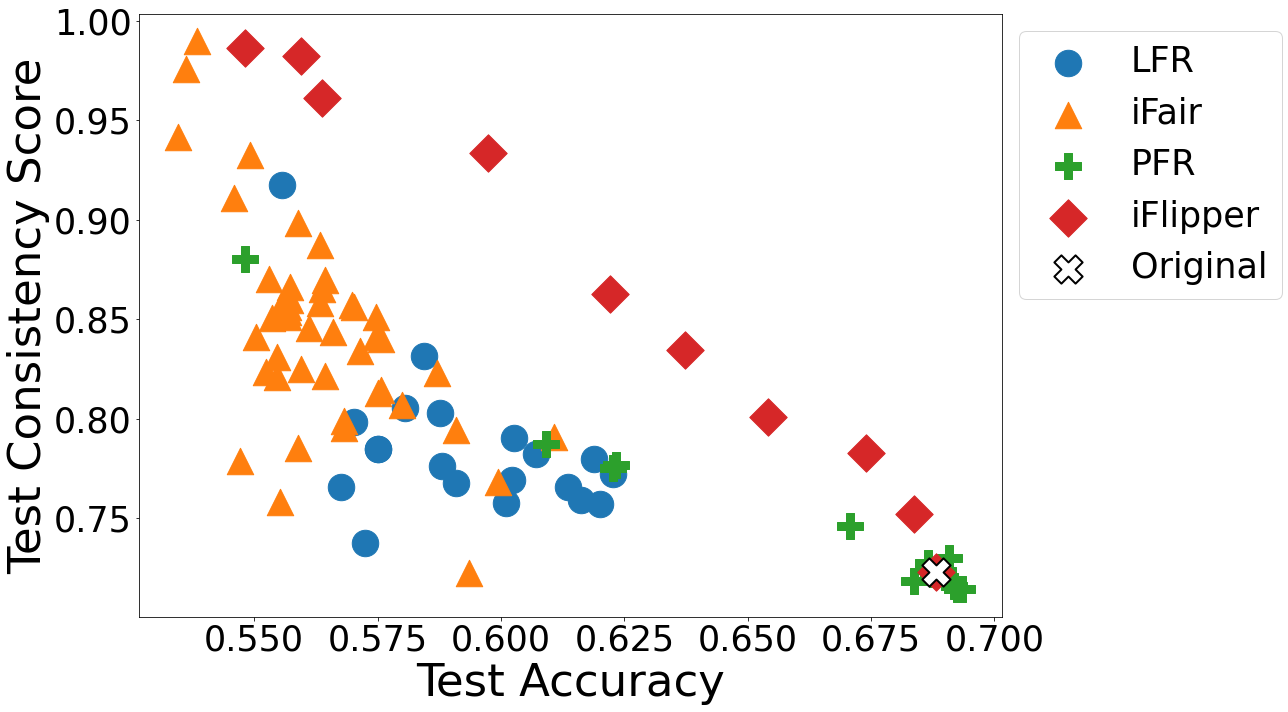

In [12]:
methods = ["LFR", "iFair", "PFR", "iFlipper", "Original"]
shapes = ["o", "^", "P", "D", "X"]
marker_size = 700

plt.figure(figsize=(18, 10))
for i in range(len(methods)):
    if methods[i] == "Original":
        plt.scatter(test_accuracy[methods[i]], test_consistency_score[methods[i]], label=methods[i], s=marker_size+100, marker=shapes[i], edgecolors="black", linewidth=2, color="white")
    else:
        plt.scatter(test_accuracy[methods[i]], test_consistency_score[methods[i]], label=methods[i], s=marker_size, marker=shapes[i]) 
        
plt.tick_params(labelsize=35)
plt.xlabel("Test Accuracy", fontsize=45)
plt.ylabel("Test Consistency Score", fontsize=45)
plt.legend(prop={'size':35}, bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()